In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import binom
from matplotlib import rcParams
import pickle

In [2]:
plt.rc('text', usetex=True)
plt.rc('axes', linewidth=2)
plt.rc('font', weight='bold')
plt.rcParams['text.latex.preamble'] = r'\usepackage{sfmath} \boldmath'
rcParams['font.family'] = 'serif'  # Use serif fonts (e.g., Times New Roman)
rcParams['font.serif'] = ['Times New Roman']  # Set Times New Roman as the preferred serif font
rcParams['font.size'] = 14  # Set the global font size
rcParams['axes.titlesize'] = 16  # Font size for the title
rcParams['axes.labelsize'] = 14  # Font size for axis labels
rcParams['legend.fontsize'] = 12  # Font size for the legend
rcParams['xtick.labelsize'] = 12  # Font size for x-axis ticks
rcParams['ytick.labelsize'] = 12  # Font size for y-axis ticks

In [3]:
random.seed(42)
P = 0.5

We are going to do an analysis that highlights the multiple testing problem. The main idea is that if we are running several independent statistical tests at the $\alpha = 0.05$ level, we actually need to correct our confidence level to be more stringent to account for the inflating Type I error. Simply stated, the more tests, the better chance of a false positive.

For this example we will begin with the Null Hypothesis that a randomly generated integer from 0 to 1 has an equal chance of coming up even or odd. Our p-values will come from the two-tailed binomial test. Let's define some parameters: $M$ is the number of random integers chosen, $P$ is the equal probablity null hypothesis of even or odd, and $N$ is the number of independent tests being run simultaneously. We have an upper bound for the Family-Wise Error Rate (FWER), which is the inflating <i>group</i> $\alpha$ level, given by $1 - (1 - \alpha)^N$.

We are going to be testing the null hypothesis of equal evens and odds at $\alpha = 0.05$ and we can do this by checking to see if we have $n_{\text{evens}} \leq \text{crit}$ or $n_{\text{evens}} \geq M - \text{crit}$. Where the critical value ($\text{crit}$) is defined by a p-value less than $\alpha$. Given a critical number of evens we would reject the null hypothesis at the $0.05$ level.

We will run this analysis $10000$ times to get an asymptotic value for the FWER. That is, how many times do we reject the null hypothesis incorrectly (Type I Error) at least once in $N$ independent tests. This value should be upper bounded by $1 - (1-\alpha)^N$.

In [4]:
def fwer_upper_bound(alpha_, N_):
    return 1 - (1 - alpha_)**N_

We use the function <i>asymp</i> to count the number of false positive analyses in $NN = 10000$ runs.

In [5]:
def asymp(N_, NN_, M_, alpha_):
    results = np.random.randint(0, 2, size=(NN_, N_, M_))
    evens = np.sum(results % 2 == 0, axis=2)
    temp_binomial = binom(M_,P)
    temp_crit = int(temp_binomial.ppf(alpha_ / 2)-1.)
    false_positives = np.sum((evens <= temp_crit) | (evens >= M_ - temp_crit), axis=1) > 0
    return np.mean(false_positives)

We will run $N$ from $1$ to $1000$ statistical tests, and also $M$ in defined by low_M, med_M, and high_M random coins flipped.

In [6]:
numer_tests = np.logspace(0,3,10)
low_M = 18
numer_fwer_low = [asymp(int(i), 10000, low_M, 0.05) for i in numer_tests]

In [7]:
med_M = 51
numer_fwer_med = [asymp(int(i), 10000, med_M, 0.05) for i in numer_tests]

In [8]:
high_M = 120
numer_fwer_high = [asymp(int(i), 10000, high_M, 0.05) for i in numer_tests]

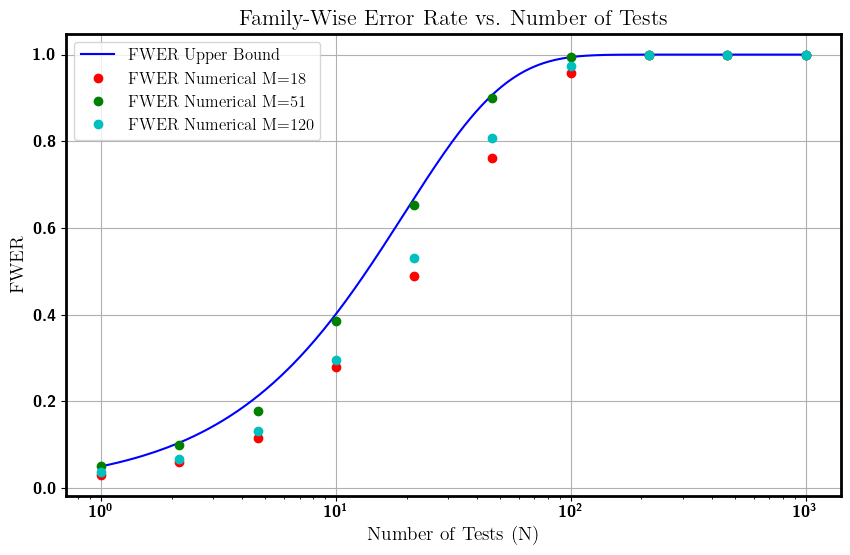

In [9]:
ubound_tests = np.arange(1, 1000, 0.1)
ubound_fwer = 1 - (1 - 0.05)**ubound_tests


plt.figure(figsize=(10, 6))
plt.plot(ubound_tests, ubound_fwer, label='FWER Upper Bound', color='blue')
plt.plot(numer_tests, numer_fwer_low, 'ro',label=f'FWER Numerical M={low_M}')
plt.plot(numer_tests, numer_fwer_med, 'go',label=f'FWER Numerical M={med_M}')
plt.plot(numer_tests, numer_fwer_high, 'co',label=f'FWER Numerical M={high_M}')
plt.xlabel('Number of Tests (N)')
plt.ylabel('FWER')
plt.xscale('log')
plt.title('Family-Wise Error Rate vs. Number of Tests')
plt.legend()
plt.grid()
plt.show()

Let's correct for the rising $\alpha$ with the Bonferroni correction where our new $\alpha = \alpha/N$.

In [10]:
numer_fwer_bonferroni_low = [asymp(int(i), 10000, low_M, 0.05/i) for i in numer_tests]

In [11]:
numer_fwer_bonferroni_med = [asymp(int(i), 10000, med_M, 0.05/i) for i in numer_tests]

In [12]:
numer_fwer_bonferroni_high = [asymp(int(i), 10000, high_M, 0.05/i) for i in numer_tests]

We compare the upper bound to the numerical false positive rate for our choice of $N$ and $M$.

Applying the Bonferroni Correction eliminates the dependence on the number of tests but because it is the most simple correction it is also the most conservative.

In [13]:
ubound_fwer_bonferroni = 1 - (1 - 0.05/ubound_tests)**ubound_tests

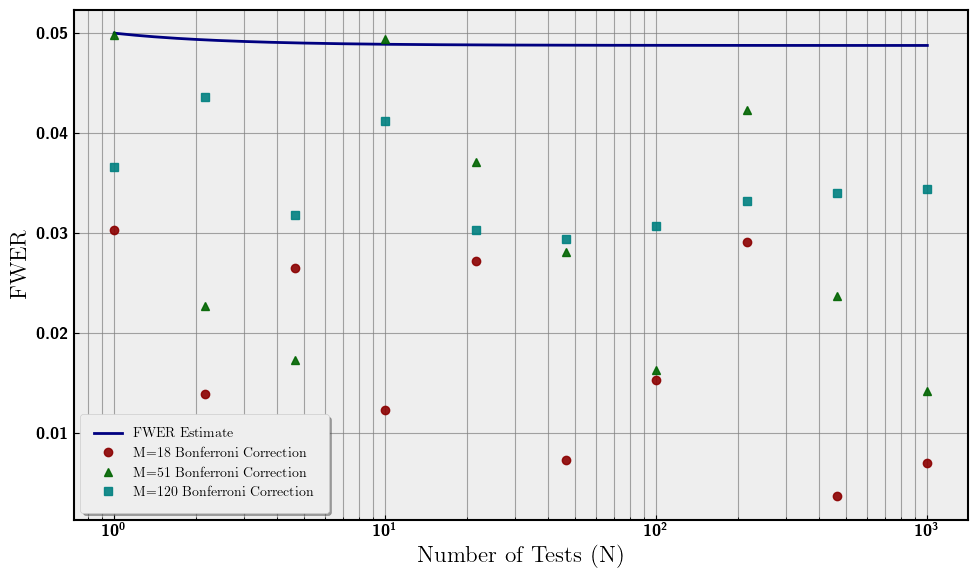

In [14]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(ubound_tests, ubound_fwer_bonferroni, label='FWER Estimate', color='navy', linewidth=2)
ax.plot(numer_tests, numer_fwer_bonferroni_low, 'o', label=f'M={low_M} Bonferroni Correction', color='darkred', markersize=6, alpha=0.9)
ax.plot(numer_tests, numer_fwer_bonferroni_med, '^', label=f'M={med_M} Bonferroni Correction', color='darkgreen', markersize=6, alpha=0.9)
ax.plot(numer_tests, numer_fwer_bonferroni_high, 's', label=f'M={high_M} Bonferroni Correction', color='teal', markersize=6, alpha=0.9)

ax.set_xlabel('Number of Tests (N)')
ax.set_ylabel('FWER')
ax.set_xscale('log')

ax.legend(loc='lower left', fontsize=10, frameon=True, shadow=True, borderpad=1)
ax.grid(which='both', linestyle='-', linewidth=0.8, color='gray', alpha=0.7)

for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

Note how med_M has a larger false positive rate than high_M. This is counter-intuitive but can be explained by calculating the p-value of the critical number of coin flips. Although the trend of critical p-values tends to $\alpha$, it oscillates wildly. For our choice of $M$ we got closer to $\alpha = 0.05$ with a lower $M$.

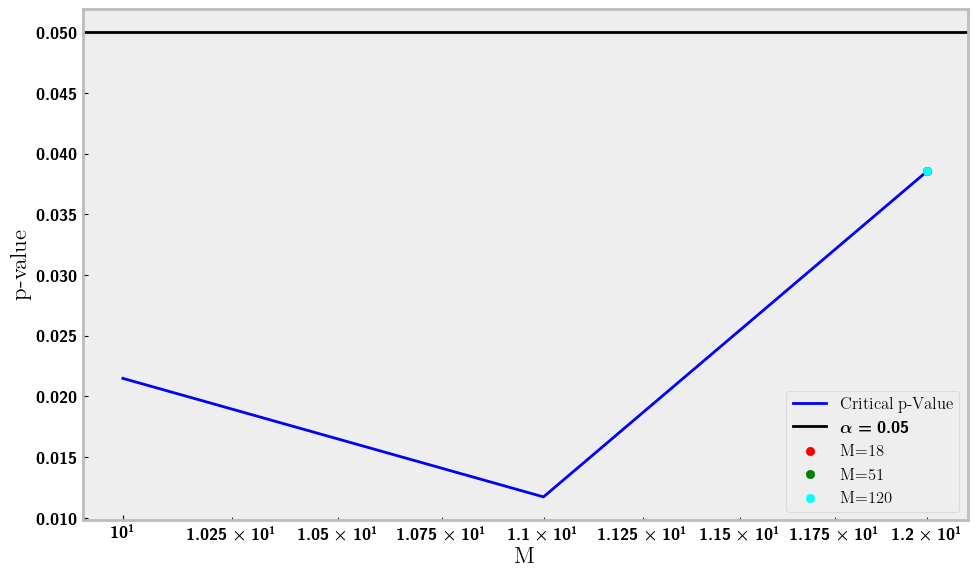

In [22]:
Ms = np.linspace(10,12,3).astype(int)
bins = [binom(i,P) for i in Ms]
crits = [int(i.ppf(0.05 / 2)-1.) for i in bins]
pvs = [2.*bins[i].cdf(min(Ms[i]-crits[i],crits[i])) for i in range(len(Ms))]
index = [min(range(len(Ms)), key=lambda i: abs(Ms[i]-low_M)), 
             min(range(len(Ms)), key=lambda i: abs(Ms[i]-med_M)), 
             min(range(len(Ms)), key=lambda i: abs(Ms[i]-high_M))
             ]
colors = ['red', 'green', 'cyan']
labels = [f'M={low_M}', f'M={med_M}', f'M={high_M}']
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(Ms, pvs, color='blue', label='Critical p-Value')
ax.axhline(0.05, color='black', label=f'$\\alpha = 0.05$')
for i in range(len(index)):
    plt.scatter(Ms[index[i]], pvs[index[i]], color=colors[i], \
                label=labels[i], zorder=2)
ax.set_xscale('log')
ax.set_xlabel('M')
ax.set_ylabel('p-value')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

In [120]:
"""with open('fwer.pkl', 'wb') as f:
    pickle.dump((numer_fwer_low, numer_fwer_med, numer_fwer_high, \
                    [low_M, med_M, high_M], \
                    numer_fwer_bonferroni_low, numer_fwer_bonferroni_med, \
                    numer_fwer_bonferroni_high, numer_tests, ubound_fwer, \
                    ubound_tests, ubound_fwer_bonferroni, Ms, pvs, index), f)"""

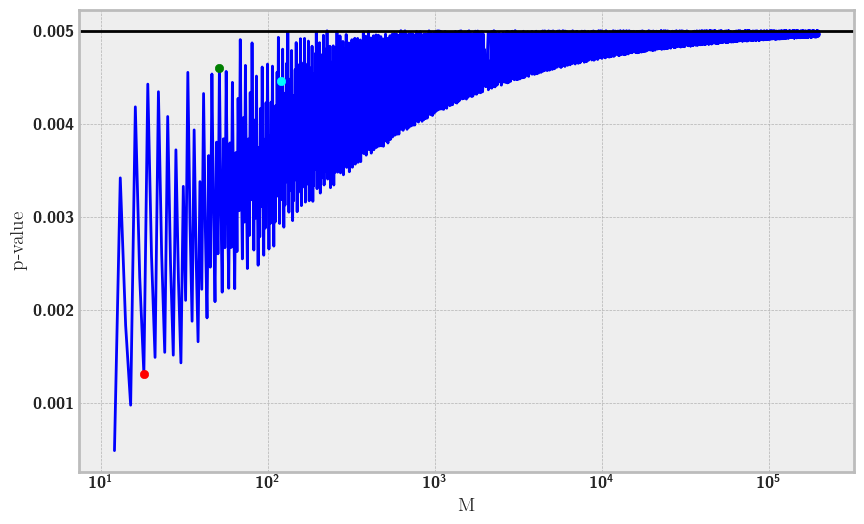

In [130]:
Ntest = 10
Ms = np.logspace(np.log(3),np.log(200),10000).astype(int)
bins = [binom(i,P) for i in Ms]
crits = [int(i.ppf(0.05/Ntest / 2)-1.) for i in bins]
pvs = [2.*bins[i].cdf(min(Ms[i]-crits[i],crits[i])) for i in range(len(Ms))]
index = [min(range(len(Ms)), key=lambda i: abs(Ms[i]-low_M)), 
             min(range(len(Ms)), key=lambda i: abs(Ms[i]-med_M)), 
             min(range(len(Ms)), key=lambda i: abs(Ms[i]-high_M))
             ]
colors = ['red', 'green', 'cyan']
labels = [f'M={low_M}', f'M={med_M}', f'M={high_M}']
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(Ms, pvs, color='blue', label='Critical p-Value')
ax.axhline(0.05/Ntest, color='black', label=f'$\\alpha = 0.05$')
for i in range(len(index)):
    plt.scatter(Ms[index[i]], pvs[index[i]], color=colors[i], \
                label=labels[i], zorder=2)
ax.set_xscale('log')
ax.set_xlabel('M')
ax.set_ylabel('p-value')
plt.show()

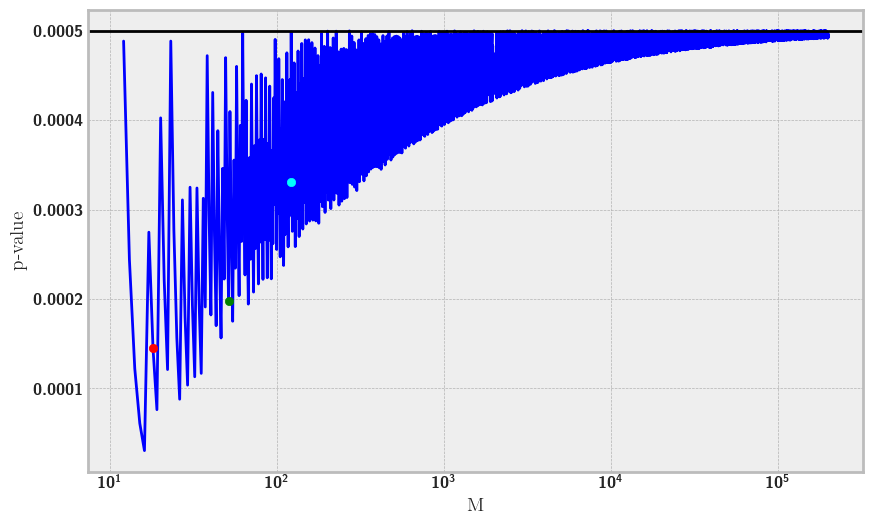

In [131]:
Ntest = 100
Ms = np.logspace(np.log(3),np.log(200),10000).astype(int)
bins = [binom(i,P) for i in Ms]
crits = [int(i.ppf(0.05/Ntest / 2)-1.) for i in bins]
pvs = [2.*bins[i].cdf(min(Ms[i]-crits[i],crits[i])) for i in range(len(Ms))]
index = [min(range(len(Ms)), key=lambda i: abs(Ms[i]-low_M)), 
             min(range(len(Ms)), key=lambda i: abs(Ms[i]-med_M)), 
             min(range(len(Ms)), key=lambda i: abs(Ms[i]-high_M))
             ]
colors = ['red', 'green', 'cyan']
labels = [f'M={low_M}', f'M={med_M}', f'M={high_M}']
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(Ms, pvs, color='blue', label='Critical p-Value')
ax.axhline(0.05/Ntest, color='black', label=f'$\\alpha = 0.05$')
for i in range(len(index)):
    plt.scatter(Ms[index[i]], pvs[index[i]], color=colors[i], \
                label=labels[i], zorder=2)
ax.set_xscale('log')
ax.set_xlabel('M')
ax.set_ylabel('p-value')
plt.show()

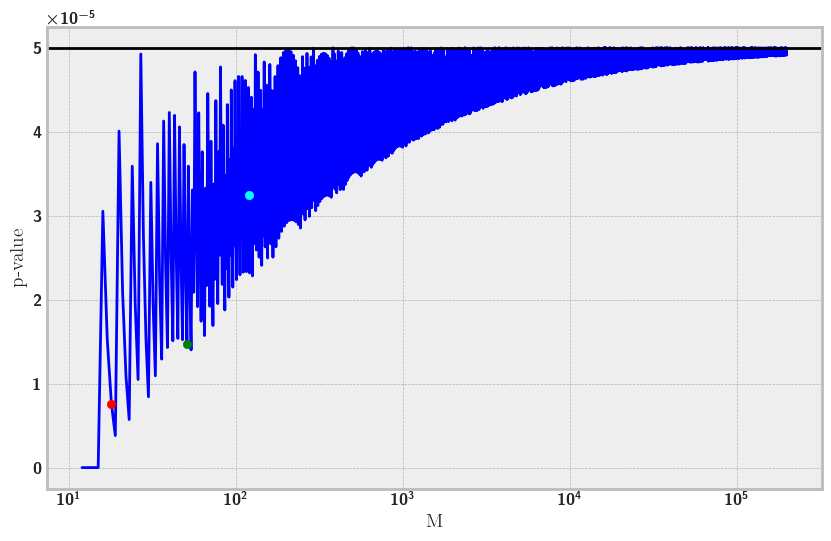

In [132]:
Ntest = 1000
Ms = np.logspace(np.log(3),np.log(200),10000).astype(int)
bins = [binom(i,P) for i in Ms]
crits = [int(i.ppf(0.05/Ntest / 2)-1.) for i in bins]
pvs = [2.*bins[i].cdf(min(Ms[i]-crits[i],crits[i])) for i in range(len(Ms))]
index = [min(range(len(Ms)), key=lambda i: abs(Ms[i]-low_M)), 
             min(range(len(Ms)), key=lambda i: abs(Ms[i]-med_M)), 
             min(range(len(Ms)), key=lambda i: abs(Ms[i]-high_M))
             ]
colors = ['red', 'green', 'cyan']
labels = [f'M={low_M}', f'M={med_M}', f'M={high_M}']
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(Ms, pvs, color='blue', label='Critical p-Value')
ax.axhline(0.05/Ntest, color='black', label=f'$\\alpha = 0.05$')
for i in range(len(index)):
    plt.scatter(Ms[index[i]], pvs[index[i]], color=colors[i], \
                label=labels[i], zorder=2)
ax.set_xscale('log')
ax.set_xlabel('M')
ax.set_ylabel('p-value')
plt.show()